# Acomodo de datos

Primero vamos a cargar los datos, los agregaremos a un array de python


In [7]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import random
import matplotlib.pyplot as plt
import numpy as np

CURRENT_DIR = Path('/content/drive')
from google.colab import drive
drive.mount(str(CURRENT_DIR))

CURRENT_DIR = CURRENT_DIR.joinpath('MyDrive','restauracion')
MODULES_DIR = CURRENT_DIR.joinpath('src')
sys.path.append(str(MODULES_DIR))
DATA_DIR = CURRENT_DIR.joinpath('Process')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
from sklearn.model_selection import train_test_split
from keras.utils import img_to_array, load_img

-----

Generaremos dos listas, una con toda la información de las imagenes en buen estado y otra lista con la información de las imagenes con defectos


In [9]:
directories_clean = sorted([f for f in DATA_DIR.joinpath('test').iterdir() if f.is_dir()])
files_clean = []
for folder in directories_clean:
    files_clean = sorted(DATA_DIR.joinpath('test',folder.name).glob('*.jpg')) + files_clean

files_clean = sorted(files_clean)
len(files_clean)

1504

In [10]:
directories_noisy = sorted([f for f in DATA_DIR.joinpath('train').iterdir() if f.is_dir()])
files_noisy = []
for folder in directories_clean:
    files_noisy = sorted(DATA_DIR.joinpath('train',folder.name).glob('*.jpg')) + files_noisy

files_noisy = sorted(files_noisy)
len(files_noisy)

1504

-----
Con estas listas generaremos las respectivas listas de entrenamiento y testeo, para posteriorme importar las imagenes

In [11]:
x_train_list, x_test_list, y_train_list, y_test_list = train_test_split(
    files_noisy,
    files_clean,
    test_size=0.2
)

Con las listas vamos a cargar los arrays

In [6]:
x_train, x_test, y_train, y_test = [], [], [], []

In [ ]:
for file in x_train_list:
    img = load_img(str(file), color_mode='rgb')
    img = img_to_array(img).astype('float16')/255
    x_train.append(img)
x_train = np.array(x_train)

In [ ]:
for file in x_test_list:
    img = load_img(str(file), color_mode='rgb')
    img = img_to_array(img).astype('float16')/255
    x_test.append(img)
x_test = np.array(x_test)

In [ ]:
for file in y_train_list:
    img = load_img(str(file), color_mode='rgb')
    img = img_to_array(img).astype('float16')/255
    y_train.append(img)
y_train = np.array(y_train)

In [ ]:
for file in y_test_list:
    img = load_img(str(file), color_mode='rgb')
    img = img_to_array(img).astype('float16')/255
    y_test.append(img)
y_test = np.array(y_test)

-----

La forma anterior de importar datos no funciona, por lo cual generaremos nuestra propia función de batch

In [12]:
from pathlib import Path
import numpy as np
import tensorflow as tf
from keras.utils import Sequence

In [21]:
class CustomImageDataGenerator(Sequence):
    def __init__(self, image_paths_noisy, image_paths_clean , batch_size, target_size, class_mode='input',shuffle=True):
        self.image_paths_noisy = image_paths_noisy
        self.image_paths_clean = image_paths_clean
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        if len(self.image_paths_clean)==len(self.image_paths_noisy):
            return int(np.ceil(len(self.image_paths_clean) / float(self.batch_size)))

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size: (idx + 1) * self.batch_size]

        batch_files_clean = self.image_paths_clean[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_files_noisy = self.image_paths_noisy[idx * self.batch_size: (idx + 1) * self.batch_size]

        batch_images_clean = [self.load_and_preprocess_image(str(file)) for file in batch_files_clean]
        batch_images_noisy = [self.load_and_preprocess_image(str(file)) for file in batch_files_noisy]

        if self.class_mode == 'input':
            return np.array(batch_images_noisy), np.array(batch_images_clean)  # Devolver imágenes de entrada y salida iguales
        elif self.class_mode == 'output':
            return np.array(batch_images_clean)  # Devolver solo las imágenes de salida (limpias)
        else:
            raise ValueError("Invalid class_mode. Use 'input' or 'output'.")

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths_clean))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_and_preprocess_image(self, file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=self.target_size, color_mode='rgb')
        img_array = tf.keras.preprocessing.image.img_to_array(img)

        img_array = img_array / 255.0
        img_array = img_array.astype('float16')

        return img_array

In [22]:
train_generator = CustomImageDataGenerator(image_paths_noisy=x_train_list,
                                           image_paths_clean=y_train_list,
                                           batch_size=32,
                                           target_size=(400,600),
                                           class_mode='input',
                                           shuffle=True)

In [25]:
x,y = train_generator.__getitem__(0)

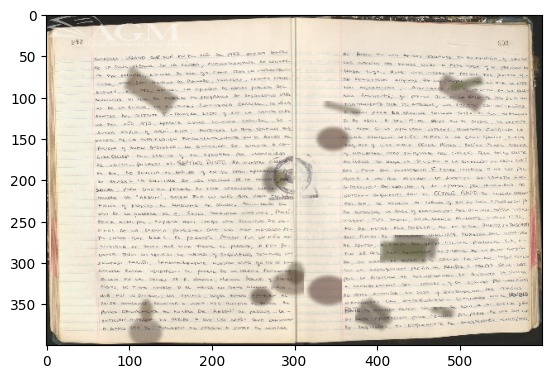

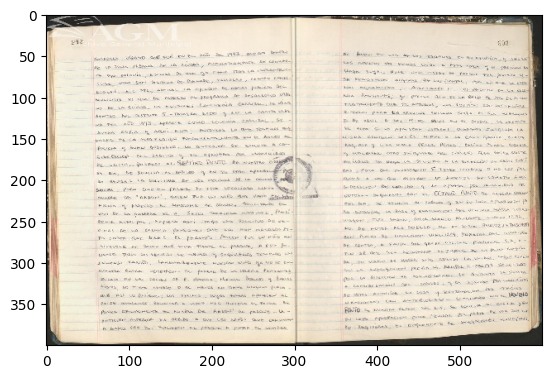

In [40]:
import matplotlib.pyplot as plt

img = np.array(x[0] * 255, dtype=np.uint8)
plt.imshow(img)
plt.show()

img = np.array(y[0] * 255, dtype=np.uint8)
plt.imshow(img)
plt.show()

Lo anterior lo guardaremos en un script de python para su facil implementación
